In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import saqqara
import sys
sys.path.insert(0, '../inference/')
sys.path.insert(0, '../simulator/')
from networks import SignalAET
from simulator import LISA_AET
from dataloader import get_datasets, setup_dataloaders, get_data_npy_dataset
import numpy as np
import torch
import matplotlib.pyplot as plt
import glob
import pickle
import swyft
import logging
log = logging.getLogger("pytorch_lightning")
log.propagate = False
log.setLevel(logging.ERROR)

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [7]:
from scipy.integrate import simps
from scipy.interpolate import interp1d
def get_sigmas(logratios):
    lrs = np.array(logratios.logratios[:, 0].reshape(int(np.sqrt(logratios.logratios.shape[0])), int(np.sqrt(logratios.logratios.shape[0]))))
    params_alpha = np.array(logratios.params[:, 0, 0].reshape(int(np.sqrt(logratios.params.shape[0])), int(np.sqrt(logratios.params.shape[0]))))
    params_gamma = np.array(logratios.params[:, 0, 1].reshape(int(np.sqrt(logratios.params.shape[0])), int(np.sqrt(logratios.params.shape[0]))))
    posterior = np.exp(lrs - np.max(lrs)) / np.sum(np.exp(lrs - np.max(lrs))) / (params_alpha[1, 0] - params_alpha[0, 0]) * (params_gamma[0, 1] - params_gamma[0, 0])
    alpha_marginal = simps(posterior, params_gamma, axis=1)
    gamma_marginal = simps(posterior, params_alpha, axis=0)
    alpha_ps = params_alpha[:, 0]
    gamma_ps = params_gamma[0, :]
    norm_alpha_marginal = alpha_marginal / simps(alpha_marginal, alpha_ps) 
    norm_gamma_marginal = gamma_marginal / simps(gamma_marginal, gamma_ps)
    alpha_cumulant =  np.cumsum(norm_alpha_marginal * (alpha_ps[1] - alpha_ps[0]))
    gamma_cumulant =  np.cumsum(norm_gamma_marginal * (gamma_ps[1] - gamma_ps[0]))
    alpha_interp = interp1d(alpha_cumulant, alpha_ps)
    gamma_interp = interp1d(gamma_cumulant, gamma_ps)
    alpha_sigma = 0.5 * (alpha_interp(0.5 + 0.34) - alpha_interp(0.5 - 0.34))
    gamma_sigma = 0.5 * (gamma_interp(0.5 + 0.34) - gamma_interp(0.5 - 0.34))
    return alpha_sigma, gamma_sigma

def get_resampling_dataset(sim, settings, path_to_data=None):
    training_settings = settings.get("train", {})
    if training_settings["type"] != "resampling":
        raise ValueError("Training type must be resampling")
    data_dir = training_settings.get("store_name") if path_to_data is None else path_to_data + training_settings.get("store_name")
    store_dataset = get_data_npy_dataset(data_dir)
    resampling_dataset = saqqara.RandomSamplingDataset(
        store_dataset,
        shuffle=training_settings.get("shuffle", True),
    )
    dataset = saqqara.ResamplingTraining(sim, resampling_dataset)
    return dataset

def get_grid(N=1000, a_low=-11.42961597442627, a_high=-10.696080207824707, g_low=-0.7066106200218201, g_high=1.0477334260940552):
    a_samples = np.linspace(a_low, a_high, N)
    g_samples = np.linspace(g_low, g_high, N)
    ag_samples = np.array(np.meshgrid(a_samples, g_samples)).T.reshape(-1, 2)
    A_samples = np.ones(N)
    P_samples = np.ones(N)
    AP_samples = np.array(np.meshgrid(A_samples, P_samples)).T.reshape(-1, 2)
    return swyft.Samples(z=np.float32(np.concatenate((ag_samples, AP_samples), axis=1)))

def get_network(id, sim):
    config = glob.glob(f"../training_dir/training_config_id={id}.yaml")[0]
    ckpt = glob.glob(f"../training_dir/saqqara-*_id={id}.ckpt")[0]
    settings = saqqara.load_settings(config_path=config)
    network = SignalAET(settings=settings, sim=sim)
    network = saqqara.load_state(network=network, ckpt=ckpt)
    return network

In [8]:
id = "G7RG" # "UD3J" #"57LN" # "SIMF", "5RU6"
config = glob.glob(f"../training_dir/training_config_id={id}.yaml")[0]
ckpt = glob.glob(f"../training_dir/saqqara-*_id={id}.ckpt")[0]
settings = saqqara.load_settings(config_path=config)
sim = LISA_AET(settings)
network = get_network(id, sim)
trainer = saqqara.setup_trainer(settings, logger=None)
dataset = get_resampling_dataset(sim, settings, path_to_data='../')

[INFO] Loading data from ../data/resampling_three_channel
[INFO] Total number of simulations: 51200
data shape: (6, 1779, 3)


In [13]:
import tqdm
N = 500
prior_samples = get_grid(N=N)
lrs_list = []
data = dataset.sample(z=np.array([-11.0, 0.0, np.random.normal(3.0, 0.6), np.random.normal(15.0, 3.0)]))
observation = swyft.Sample(z=data['z'], data=data['data'])
for id in ["G7RG"]:#, "UD3J", "57LN", "SIMF"]:
    for _ in tqdm.tqdm(range(1)):
        network = get_network(id, sim)
        logratios = trainer.infer(network, observation, prior_samples, batch_size=100000)
        lrs_list.append(logratios)

  0%|          | 0/1 [00:00<?, ?it/s]

/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 3/3 [00:00<00:00,  5.02it/s] 

100%|██████████| 1/1 [00:01<00:00,  1.10s/it]

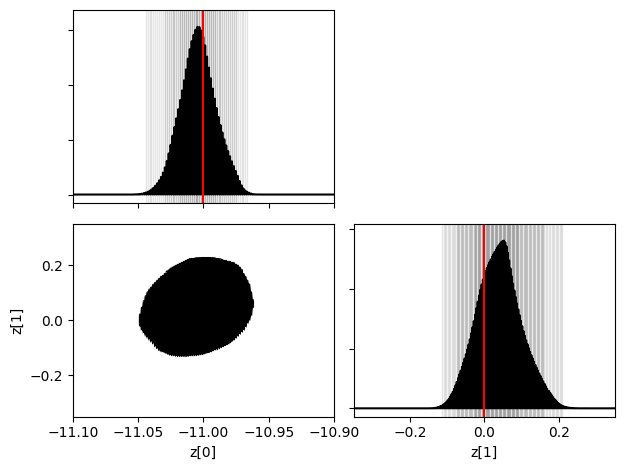

In [14]:
# swyft.plot_corner(logratios, parnames=logratios.parnames[0], bins=1000, smooth=0.0)
swyft.plot_corner(lrs_list[0], parnames=["z[0]", "z[1]"], bins=1000, smooth=0.0)
colors = ['red', 'green', 'blue']
for i in range(1, len(lrs_list)): swyft.plot_corner(lrs_list[i], parnames=["z[0]", "z[1]"], color=colors[i - 1], bins=1000, smooth=0.0, fig=plt.gcf())
#swyft.plot_corner(old_logratios, parnames=logratios.parnames[0], bins=1000, smooth=0.0, color='blue', fig=plt.gcf())
lims = [[-11.1, -10.9], [-0.35, 0.35]]
for j in range(2):
    ax = plt.subplot(2, 2, 2 * j + j + 1)
    plt.axvline(observation["z"][j], c="r")
for i in range(2):
    for j in range(i + 1):
        ax = plt.subplot(2, 2, 2 * i + j + 1)
        if i != j:
            ax.set_xlim(lims[j])
            ax.set_ylim(lims[i])
        elif i == j:
            ax.set_xlim(lims[i])

In [ ]:
prior_samples

(array([[4.3408713 , 3.94624663, 3.15699731, ..., 3.55162197, 3.15699731,
         2.36774798],
        [4.73549596, 3.94624663, 5.13012062, ..., 1.97312332, 3.55162197,
         3.55162197],
        [4.73549596, 5.91936995, 4.3408713 , ..., 3.94624663, 3.55162197,
         3.55162197],
        ...,
        [3.94624663, 3.55162197, 3.15699731, ..., 4.73549596, 5.13012062,
         4.3408713 ],
        [5.13012062, 4.73549596, 2.76237264, ..., 2.76237264, 5.13012062,
         5.13012062],
        [5.13012062, 3.15699731, 4.3408713 , ..., 1.97312332, 3.55162197,
         3.94624663]]),
 array([-11.12569523, -11.1233926 , -11.12108997, -11.11878735,
        -11.11648472, -11.11418209, -11.11187946, -11.10957684,
        -11.10727421, -11.10497158, -11.10266895, -11.10036633,
        -11.0980637 , -11.09576107, -11.09345844, -11.09115582,
        -11.08885319, -11.08655056, -11.08424793, -11.0819453 ,
        -11.07964268, -11.07734005, -11.07503742, -11.07273479,
        -11.07043217, -11

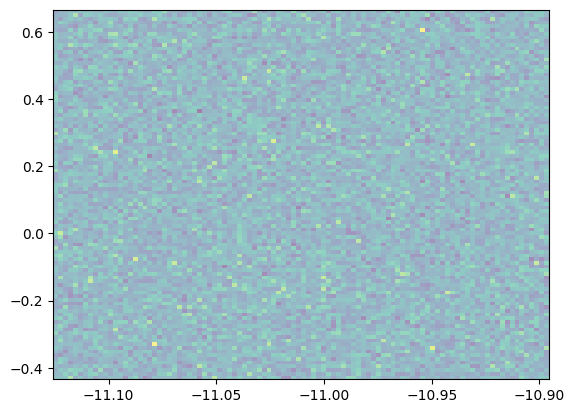

In [25]:
plt.hist2d(prior_samples["z"][:, 0], prior_samples["z"][:, 1], bins=100, density=True, alpha=0.5)

In [15]:
prior_samples = swyft.Samples(z=torch.tensor(sim.prior.sample(10_000)).float())
#coverage_data = dataset.sample(z=np.vstack([np.array([-11.0, 0.0, np.random.normal(3., 0.6), np.random.normal(15.0, 3.0)]) for _ in range(2000)]))
coverage_data = dataset.sample(z=sim.prior.sample(4000))
dm = swyft.Samples(z=torch.tensor(coverage_data['z']).float(), data=torch.tensor(coverage_data['data']).float())
coverage_samples = trainer.test_coverage(get_network(id="G7RG", sim=sim), dm, prior_samples, batch_size=100000)

/tmp/ipykernel_1776902/2509561833.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dm = swyft.Samples(z=torch.tensor(coverage_data['z']).float(), data=torch.tensor(coverage_data['data']).float())
/home/alveyjbg/mambaforge/envs/default/lib/python3.11/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/alveyjbg/mambaforge/envs/default/lib/python3.1 ...
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 4000/4000 [03:04<00:00, 21.74it/s]


In [30]:
prior_samples = swyft.Samples(z=torch.tensor(sim.prior.sample(1_000_000)).float())
#coverage_data = dataset.sample(z=np.vstack([np.array([-11.0, 0.0, np.random.normal(3., 0.6), np.random.normal(15.0, 3.0)]) for _ in range(2000)]))
#coverage_data = dataset.sample(z=sim.prior.sample(400))
dm = swyft.Samples(z=torch.tensor(coverage_data['z']).float(), data=torch.tensor(coverage_data['data']).float())
coverage_samples = trainer.test_coverage(get_network(id="UD3J", sim=sim), dm, prior_samples, batch_size=100000)

/tmp/ipykernel_4038823/2970632741.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dm = swyft.Samples(z=torch.tensor(coverage_data['z']).float(), data=torch.tensor(coverage_data['data']).float())


Predicting DataLoader 0: 100%|██████████| 4000/4000 [43:52<00:00,  1.52it/s]


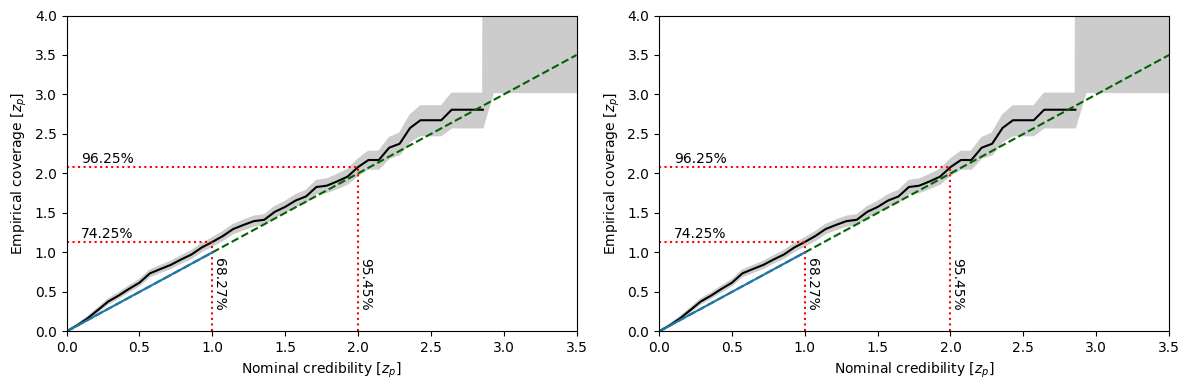

In [31]:
fix, axes = plt.subplots(1, 2, figsize = (12, 4))
for i in range(2):
    ax = axes[i]
    ax.plot([0, 0], [1, 1], c='r')
    swyft.plot_zz(coverage_samples, ['z[0]', 'z[1]'], ax = axes[i])
    axes[i].plot([0.0, 1.0], [0.0, 1.0])
plt.tight_layout()

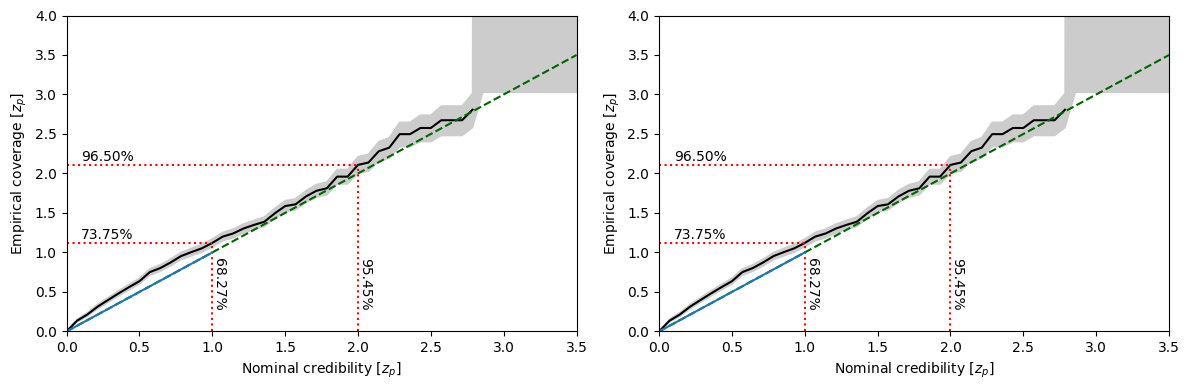

In [29]:
fix, axes = plt.subplots(1, 2, figsize = (12, 4))
for i in range(2):
    ax = axes[i]
    ax.plot([0, 0], [1, 1], c='r')
    swyft.plot_zz(coverage_samples, ['z[0]', 'z[1]'], ax = axes[i])
    axes[i].plot([0.0, 1.0], [0.0, 1.0])
plt.tight_layout()

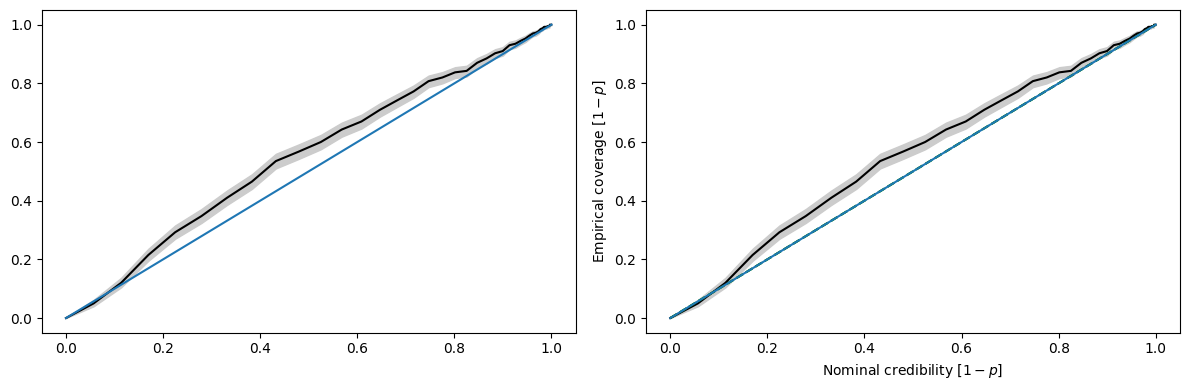

In [21]:
fix, axes = plt.subplots(1, 2, figsize = (12, 4))
for i in range(2):
    ax = axes[i]
    ax.plot([0, 0], [1, 1], c='r')
    swyft.plot_pp(coverage_samples, ['z[0]', 'z[1]'], ax = axes[i])
    axes[i].plot([0.0, 1.0], [0.0, 1.0])
plt.tight_layout()

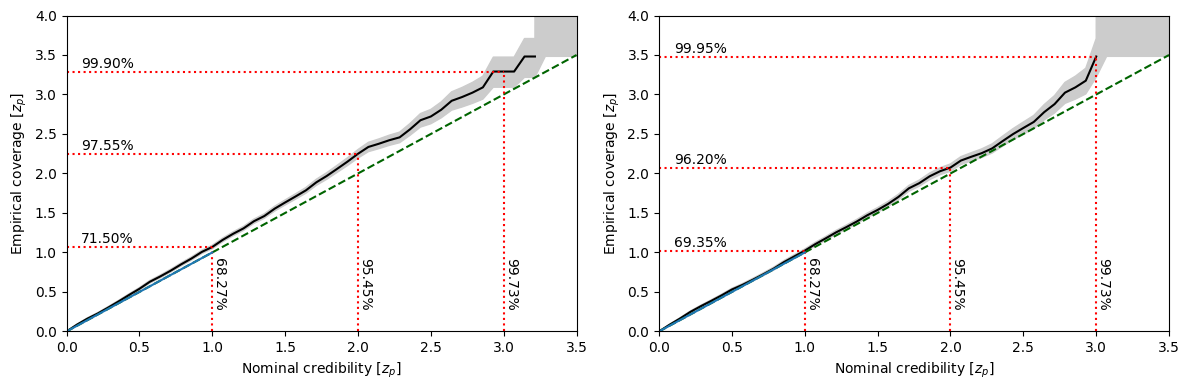

In [26]:
fix, axes = plt.subplots(1, 2, figsize = (12, 4))
for i in range(2):
    ax = axes[i]
    ax.plot([0, 0], [1, 1], c='r')
    swyft.plot_zz(coverage_samples, [f'z[{i}]'], ax = axes[i])
    axes[i].plot([0.0, 1.0], [0.0, 1.0])
plt.tight_layout()

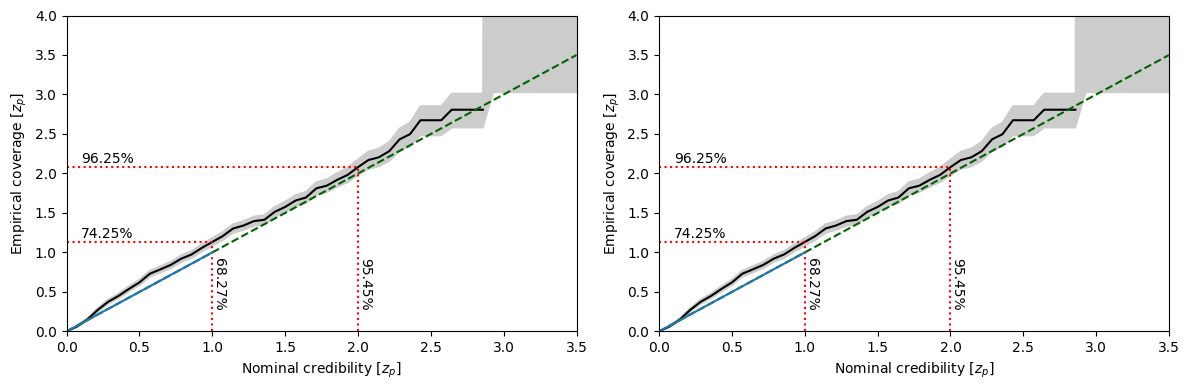

In [22]:
fix, axes = plt.subplots(1, 2, figsize = (12, 4))
for i in range(2):
    ax = axes[i]
    ax.plot([0, 0], [1, 1], c='r')
    swyft.plot_zz(coverage_samples, ['z[0]', 'z[1]'], ax = axes[i])
    axes[i].plot([0.0, 1.0], [0.0, 1.0])
plt.tight_layout()

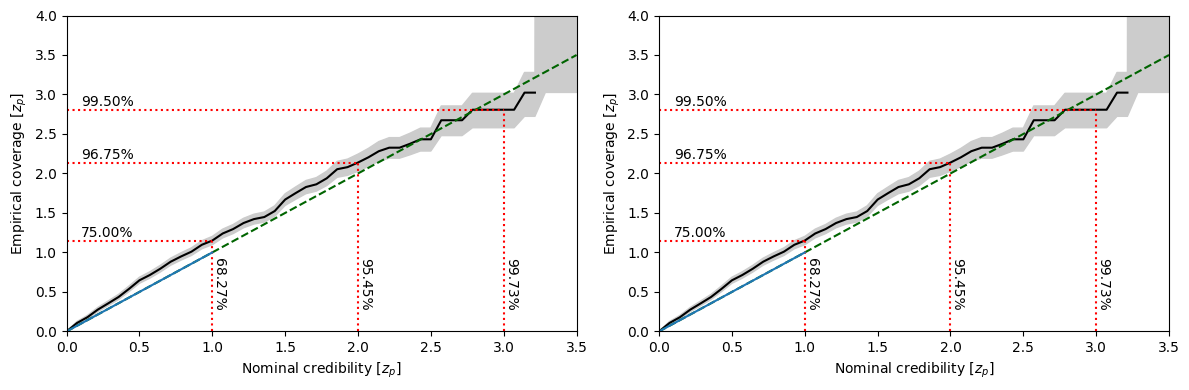

In [15]:
fix, axes = plt.subplots(1, 2, figsize = (12, 4))
for i in range(2):
    ax = axes[i]
    ax.plot([0, 0], [1, 1], c='r')
    swyft.plot_zz(coverage_samples, ['z[0]', 'z[1]'], ax = axes[i])
    axes[i].plot([0.0, 1.0], [0.0, 1.0])
plt.tight_layout()

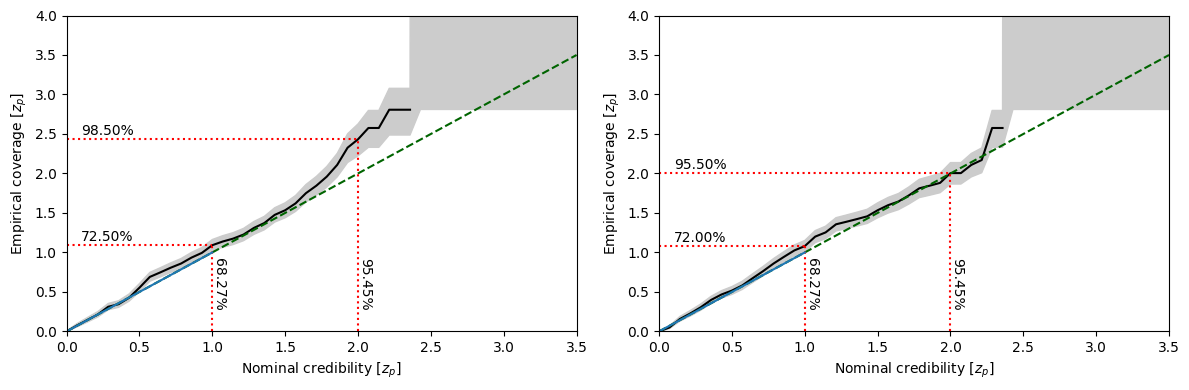

In [29]:
fix, axes = plt.subplots(1, 2, figsize = (12, 4))
for i in range(2):
    ax = axes[i]
    ax.plot([0, 0], [1, 1], c='r')
    swyft.plot_zz(coverage_samples, [f'z[{i}]'], ax = axes[i])
    axes[i].plot([0.0, 1.0], [0.0, 1.0])
plt.tight_layout()

In [ ]:
fix, axes = plt.subplots(1, 2, figsize = (12, 4))
for i in range(2):
    ax = axes[i]
    ax.plot([0, 0], [1, 1], c='r')
    swyft.plot_pp(coverage_samples, [f'z[{i}]'], ax = axes[i])
    axes[i].plot([0.0, 1.0], [0.0, 1.0])
    axes[i].fill_between(np.linspace(0, 1, 1000), y1=np.quantile(dists, q=[0.025], axis=0)[0], y2=np.quantile(dists, q=[0.975], axis=0)[0], color='C1', alpha=0.8, zorder=-10)
plt.tight_layout()

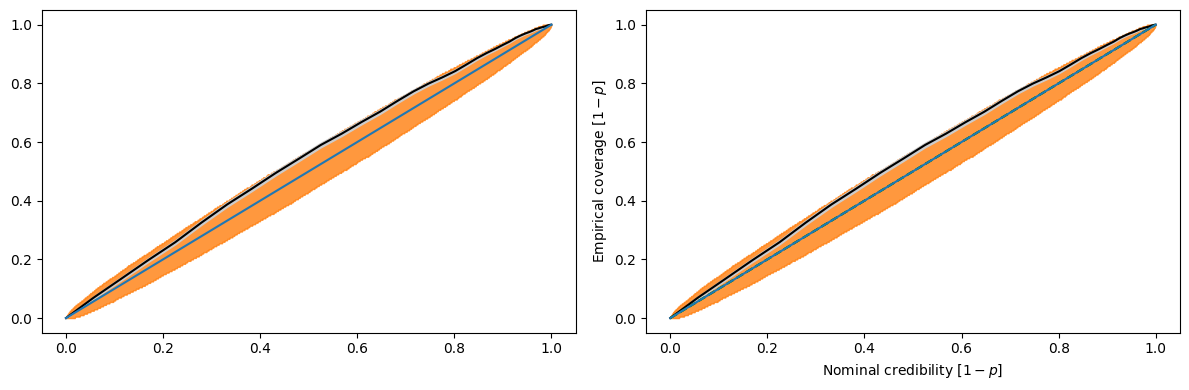

In [18]:
fix, axes = plt.subplots(1, 2, figsize = (12, 4))
for i in range(2):
    ax = axes[i]
    ax.plot([0, 0], [1, 1], c='r')
    swyft.plot_pp(coverage_samples, ['z[0]', 'z[1]'], ax = axes[i])
    axes[i].plot([0.0, 1.0], [0.0, 1.0])
    axes[i].fill_between(np.linspace(0, 1, 1000), y1=np.quantile(dists, q=[0.025], axis=0)[0], y2=np.quantile(dists, q=[0.975], axis=0)[0], color='C1', alpha=0.8, zorder=-10)
plt.tight_layout()

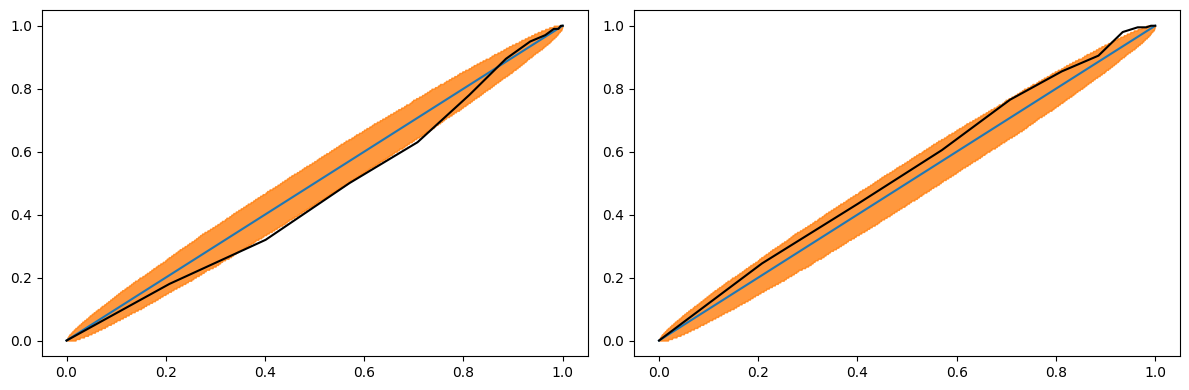

In [65]:
fix, axes = plt.subplots(1, 2, figsize = (12, 4))
from scipy import stats
def get_alpha(z_score):
    """Recover the alpha (significance level) given by `alpha = 2 * (1 - normal_cdf(z_score))`.

    Args:
        z_score: z_score aka `z`

    Returns:
        alpha: significance level
    """
    return 2 * (1 - stats.norm.cdf(z_score))


for i in range(2):
    ax = axes[i]
    ax.plot([0, 0], [1, 1], c='r')
    cov = swyft.estimate_coverage(coverage_samples, [f'z[{i}]'], z_max=5., bins=20)
    alphas = 1 - get_alpha(cov)
    #swyft.plot_pp(coverage_samples, [f'z[{i}]'], ax = axes[i])
    axes[i].plot([0.0, 1.0], [0.0, 1.0])
    axes[i].plot(alphas[:, 0], alphas[:, 1], c='k')
    axes[i].fill_between(np.linspace(0, 1, 1000), y1=np.quantile(dists, q=[0.025], axis=0)[0], y2=np.quantile(dists, q=[0.975], axis=0)[0], color='C1', alpha=0.8, zorder=-10)
plt.tight_layout()

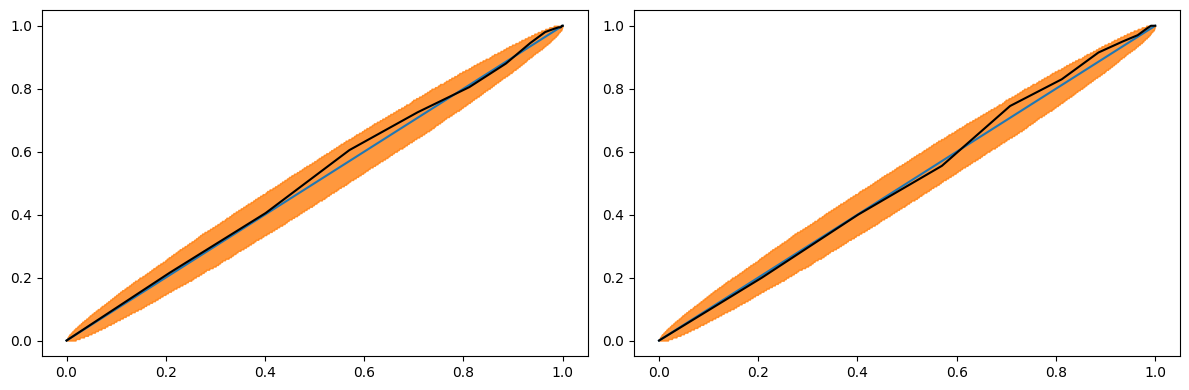

In [67]:
fix, axes = plt.subplots(1, 2, figsize = (12, 4))
from scipy import stats
def get_alpha(z_score):
    """Recover the alpha (significance level) given by `alpha = 2 * (1 - normal_cdf(z_score))`.

    Args:
        z_score: z_score aka `z`

    Returns:
        alpha: significance level
    """
    return 2 * (1 - stats.norm.cdf(z_score))


for i in range(2):
    ax = axes[i]
    ax.plot([0, 0], [1, 1], c='r')
    cov = swyft.estimate_coverage(coverage_samples, [f'z[{i}]'], z_max=5., bins=50)
    alphas = 1 - get_alpha(cov)
    #swyft.plot_pp(coverage_samples, [f'z[{i}]'], ax = axes[i])
    axes[i].plot([0.0, 1.0], [0.0, 1.0])
    axes[i].plot(alphas[:, 0], alphas[:, 1], c='k')
    axes[i].fill_between(np.linspace(0, 1, 1000), y1=np.quantile(dists, q=[0.025], axis=0)[0], y2=np.quantile(dists, q=[0.975], axis=0)[0], color='C1', alpha=0.8, zorder=-10)
plt.tight_layout()

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:06<00:00, 152.37it/s]


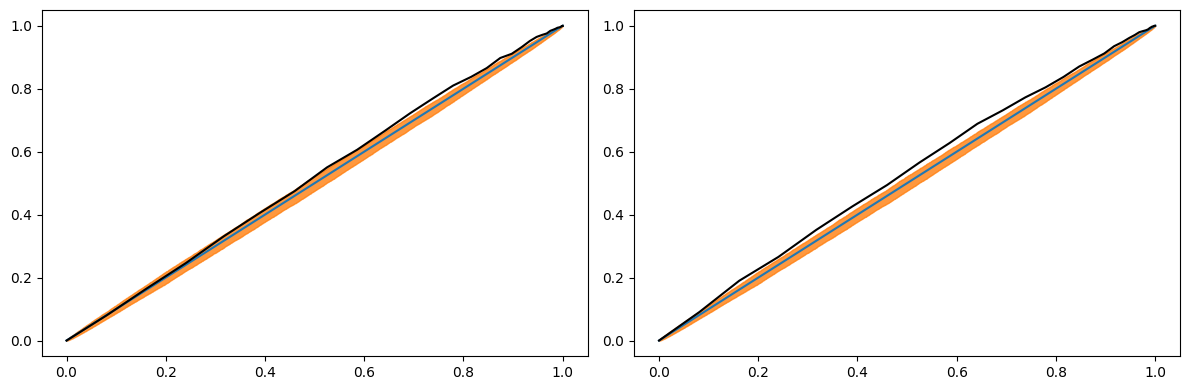

In [70]:
dists = np.vstack([get_cumulative_dist(np.random.uniform(0, 1, 2000)) for _ in tqdm.tqdm(range(1000))])
fix, axes = plt.subplots(1, 2, figsize = (12, 4))
for i in range(2):
    ax = axes[i]
    ax.plot([0, 0], [1, 1], c='r')
    cov = swyft.estimate_coverage(coverage_samples, [f'z[{i}]'], z_max=5., bins=50)
    alphas = 1 - get_alpha(cov)
    #swyft.plot_pp(coverage_samples, [f'z[{i}]'], ax = axes[i])
    axes[i].plot([0.0, 1.0], [0.0, 1.0])
    axes[i].plot(alphas[:, 0], alphas[:, 1], c='k')
    axes[i].fill_between(np.linspace(0, 1, 1000), y1=np.quantile(dists, q=[0.025], axis=0)[0], y2=np.quantile(dists, q=[0.975], axis=0)[0], color='C1', alpha=0.8, zorder=-10)
plt.tight_layout()

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:02<00:00, 439.54it/s]


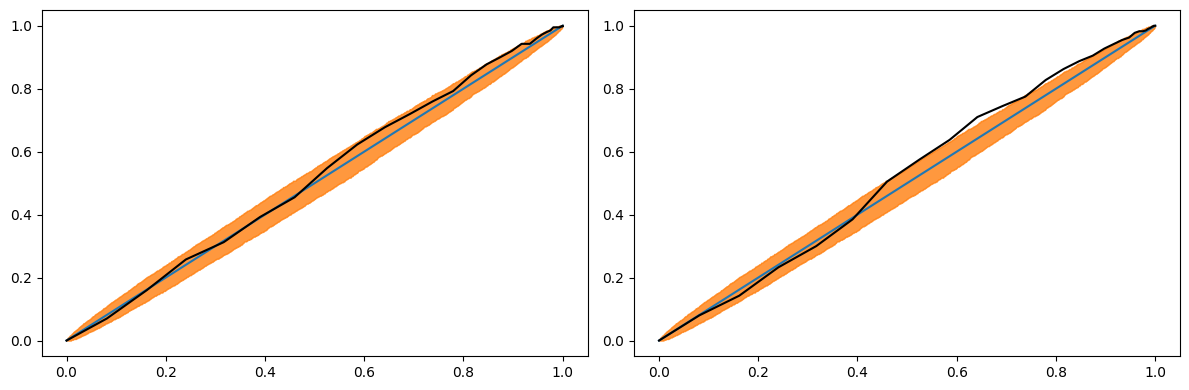

In [90]:
dists = np.vstack([get_cumulative_dist(np.random.uniform(0, 1, 400)) for _ in tqdm.tqdm(range(1000))])
fix, axes = plt.subplots(1, 2, figsize = (12, 4))
for i in range(2):
    ax = axes[i]
    ax.plot([0, 0], [1, 1], c='r')
    cov = swyft.estimate_coverage(coverage_samples, [f'z[{i}]'], z_max=5., bins=50)
    alphas = 1 - get_alpha(cov)
    #swyft.plot_pp(coverage_samples, [f'z[{i}]'], ax = axes[i])
    axes[i].plot([0.0, 1.0], [0.0, 1.0])
    axes[i].plot(alphas[:, 0], alphas[:, 1], c='k')
    axes[i].fill_between(np.linspace(0, 1, 1000), y1=np.quantile(dists, q=[0.025], axis=0)[0], y2=np.quantile(dists, q=[0.975], axis=0)[0], color='C1', alpha=0.8, zorder=-10)
plt.tight_layout()

In [16]:
def get_cumulative_dist(sample):
    dist = []
    for pt in np.linspace(0, 1, 1000):
        dist.append(len(sample[sample < pt]) / len(sample))
    return np.array(dist)

100%|██████████| 4000/4000 [00:06<00:00, 573.27it/s]


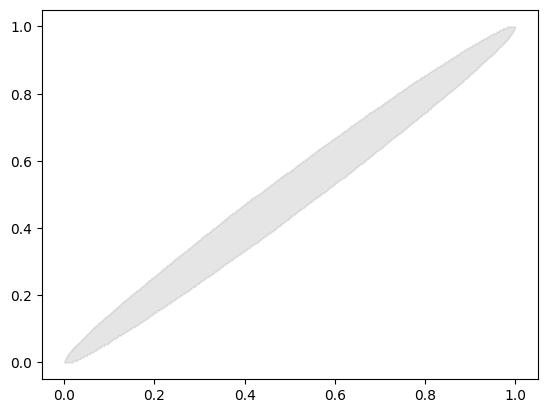

In [17]:
dists = np.vstack([get_cumulative_dist(np.random.uniform(0, 1, 200)) for _ in tqdm.tqdm(range(4000))])
plt.fill_between(np.linspace(0, 1, 1000), y1=np.quantile(dists, q=[0.025], axis=0)[0], y2=np.quantile(dists, q=[0.975], axis=0)[0], color='gray', alpha=0.2)

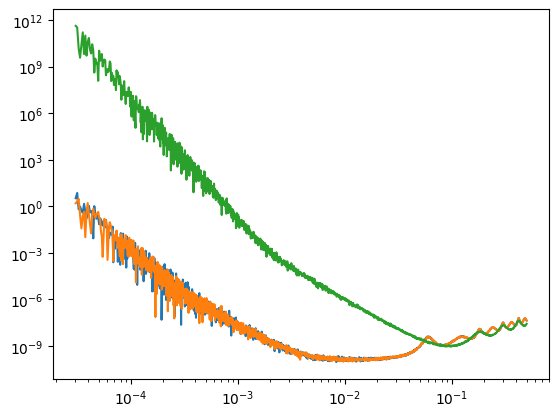

In [22]:
sample = dataset.sample(z=np.array([-11.0, 0.0, 3.0, 15.0]))
plt.loglog(sim.coarse_grained_f, sample["data"])

In [33]:
dists = np.vstack([get_cumulative_dist(np.random.uniform(0, 1, 2000)) for _ in tqdm.tqdm(range(1000))])

100%|██████████| 1000/1000 [00:06<00:00, 153.89it/s]


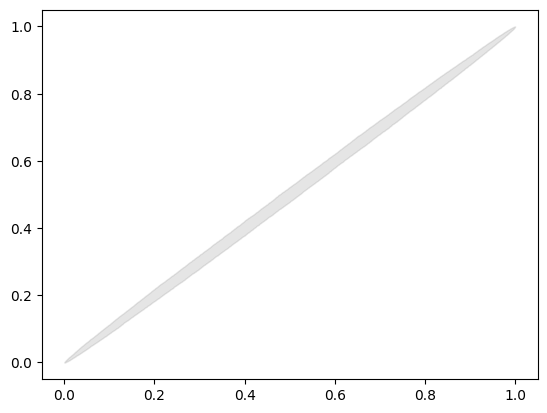

In [42]:
plt.fill_between(np.linspace(0, 1, 1000), y1=np.quantile(dists, q=[0.025], axis=0)[0], y2=np.quantile(dists, q=[0.975], axis=0)[0], color='gray', alpha=0.2)